# Градиентный бустинг

**Задача:** предсказать `Customer Lifetime Value` (CLV) по признакам клиента/полиса.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
DATA_PATH = "WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv"
data = pd.read_csv(DATA_PATH)
data.head()


,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Часть 1. EDA

In [3]:
display(data.info())
display(data.describe(include="all").T)


<class 'pandas.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   str    
 1   State                          9134 non-null   str    
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   str    
 4   Coverage                       9134 non-null   str    
 5   Education                      9134 non-null   str    
 6   Effective To Date              9134 non-null   str    
 7   EmploymentStatus               9134 non-null   str    
 8   Gender                         9134 non-null   str    
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   str    
 11  Marital Status                 9134 non-null   str    
 12  Monthly Premium Auto           9134 non-null   int64  
 13 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer,9134,9134,BU79786,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,9134,5,California,3150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Lifetime Value,9134.0,NaN,NaN,NaN,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.38119
Response,9134,2,No,7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coverage,9134,3,Basic,5568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,9134,5,Bachelor,2748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Effective To Date,9134,59,1/10/11,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmploymentStatus,9134,5,Employed,5698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,9134,2,F,4658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,9134.0,NaN,NaN,NaN,37657.380009,30379.904734,0.0,0.0,33889.5,62320.0,99981.0


In [4]:
na = data.isna().sum().sort_values(ascending=False)
display(na[na > 0])
display(data.dtypes)

Series([], dtype: int64)

Customer                             str
State                                str
Customer Lifetime Value          float64
Response                             str
Coverage                             str
Education                            str
Effective To Date                    str
EmploymentStatus                     str
Gender                               str
Income                             int64
Location Code                        str
Marital Status                       str
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy Type                          str
Policy                               str
Renew Offer Type                     str
Sales Channel                        str
Total Claim Amount               float64
Vehicle Class                        str
Vehicle Size                         str
dtype: object

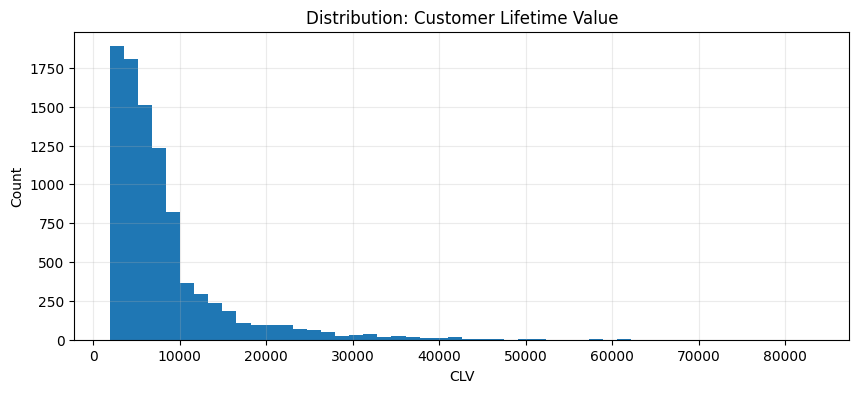

CLV quantiles:


0.01     2230.433731
0.05     2475.109047
0.10     2661.757835
0.50     5780.182197
0.90    15433.385306
0.95    22064.361267
0.99    35971.104520
Name: Customer Lifetime Value, dtype: float64

In [5]:
# целевая переменная
target_col = "Customer Lifetime Value"

plt.figure(figsize=(10, 4))
plt.hist(data[target_col].dropna(), bins=50)
plt.title("Distribution: Customer Lifetime Value")
plt.xlabel("CLV")
plt.ylabel("Count")
plt.grid(True, alpha=0.25)
plt.show()

print("CLV quantiles:")
display(data[target_col].quantile([0.01,0.05,0.1,0.5,0.9,0.95,0.99]))


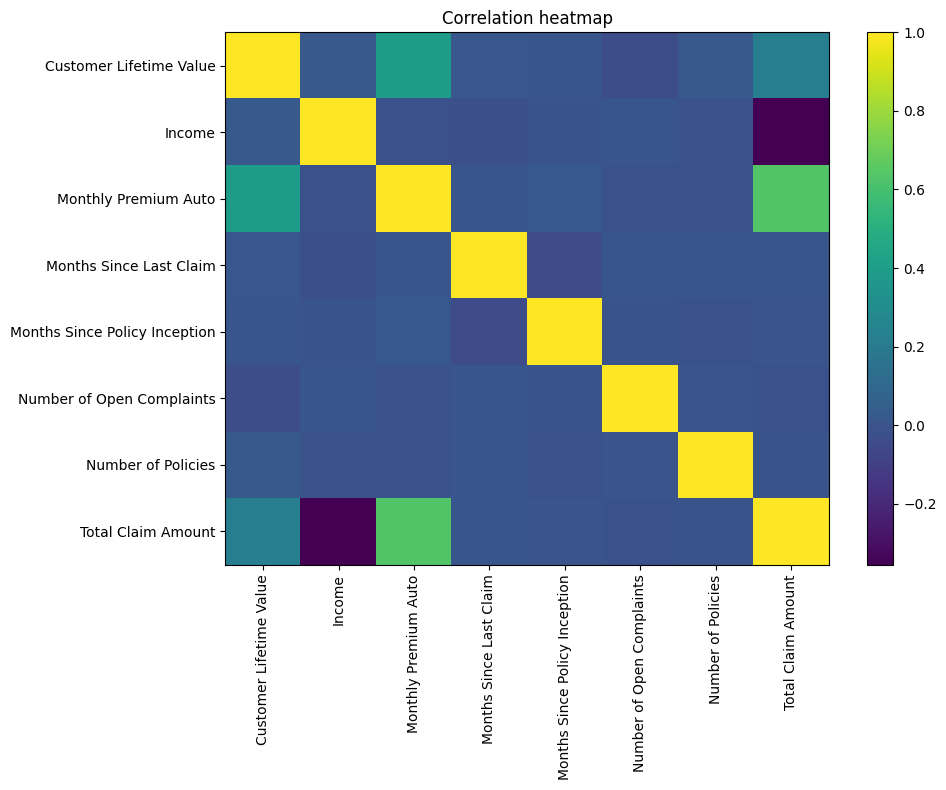

In [6]:
num_cols = data.select_dtypes(include=["number"]).columns.tolist()

corr = data[num_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()


## Часть 2.

In [8]:
# 1) уберём идентификатор клиента (обычно это шум/ID)
# 2) преобразуем дату + сделаем календарные фичи
# 3) добавим несколько простых производных признаков от текущих
# 4) используем лейбл энкодер для категориальных признаков
# 5) поделим на тест и трейн

data = data.copy()

# можем удалить, смысла не несет особого, просто айди
if "Customer" in data.columns:
    data = data.drop(columns=["Customer"])

# преобразуем дату в отдельные циферки
date_col = "Effective To Date"
if date_col in data.columns:
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")
    data["Year"] = data[date_col].dt.year
    data["Month"] = data[date_col].dt.month
    data["Day_of_Week"] = data[date_col].dt.dayofweek
    data = data.drop(columns=[date_col])

data = data.replace([np.inf, -np.inf], np.nan)

# X / y
target_col = "Customer Lifetime Value"
y = data[target_col].copy()
X = data.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# LabelEncoder для категориальных
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
encoders = {}

for c in cat_cols:
    le = LabelEncoder()
    X_train[c] = le.fit_transform(X_train[c].astype(str))
    X_test[c] = le.transform(X_test[c].astype(str))
    encoders[c] = le

for c in X_train.columns:
    X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
    X_test[c] = pd.to_numeric(X_test[c], errors="coerce")

train_mask = X_train.notna().all(axis=1) & y_train.notna()
test_mask = X_test.notna().all(axis=1) & y_test.notna()

X_train = X_train.loc[train_mask].reset_index(drop=True)
y_train = y_train.loc[train_mask].reset_index(drop=True)

X_test = X_test.loc[test_mask].reset_index(drop=True)
y_test = y_test.loc[test_mask].reset_index(drop=True)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (7307, 24) X_test: (1827, 24)


/var/folders/bn/cxh93zlj12nby29yt8z5k53w0000gn/T/ipykernel_1698/1055226231.py:34: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


In [9]:
def eval_reg(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


## Часть 3. Обучение


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

# sklearn
sk_gb = GradientBoostingRegressor()

# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    verbosity=0
)

# CatBoost
from catboost import CatBoostRegressor
cat = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

# LightGBM
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    random_state=42,
    verbose=-1
)

models = {
    "sklearn_GB": sk_gb,
    "XGBoost": xgb,
    "CatBoost": cat,
    "LightGBM": lgbm
}

baseline_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    row = {"model": name, **eval_reg(y_test, pred)}
    baseline_results.append(row)

baseline_df = pd.DataFrame(baseline_results).sort_values("RMSE")
baseline_df


,model,RMSE,MAE,R2
2,CatBoost,3996.995106,1727.767083,0.690005
3,LightGBM,4038.111455,1593.942353,0.683594
0,sklearn_GB,4141.523559,1747.501482,0.667181
1,XGBoost,4170.657690,1900.876741,0.662482


### Лидер baseline

In [11]:
leader = baseline_df.iloc[0]
print("Baseline leader:", leader["model"])
display(leader)


Baseline leader: CatBoost


model       CatBoost
RMSE     3996.995106
MAE      1727.767083
R2          0.690005
Name: 2, dtype: object

## Тюнинг гиперпараметров на кросс-валидации

In [12]:
# 5 фолдов
cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_sklearn = {
    "n_estimators": [200, 400, 800, 1200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5],
}

param_xgb = {
    "n_estimators": [300, 600, 1000, 1500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 8],
}

param_cat = {
    "iterations": [400, 800, 1200, 1600],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "depth": [4, 6, 8, 10],
}

param_lgbm = {
    "n_estimators": [400, 800, 1200, 1600],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "num_leaves": [15, 31, 63, 127],
}

search_space = {
    "sklearn_GB": (GradientBoostingRegressor(random_state=42), param_sklearn),
    "XGBoost": (XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0), param_xgb),
    "CatBoost": (CatBoostRegressor(loss_function="RMSE", random_seed=42, verbose=False), param_cat),
    "LightGBM": (LGBMRegressor(random_state=42, verbose=-1), param_lgbm),
}

tuned_results = []
best_params = {}

for name, (estimator, params) in search_space.items():
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=params,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        random_state=42,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    pred = best.predict(X_test)

    tuned_results.append({"model": name, **eval_reg(y_test, pred)})
    best_params[name] = search.best_params_

tuned_df = pd.DataFrame(tuned_results).sort_values("RMSE")
tuned_df


,model,RMSE,MAE,R2
2,CatBoost,3945.135394,1585.495008,0.697997
3,LightGBM,3983.782391,1453.861950,0.692051
1,XGBoost,4102.724148,1697.976319,0.673388
0,sklearn_GB,4152.122170,1639.608455,0.665475


### Кто победил после тюнинга + лучшие параметры

In [13]:
leader_tuned = tuned_df.iloc[0]
print("Tuned leader:", leader_tuned["model"])
display(leader_tuned)

print("\nBest params:")
for k, v in best_params.items():
    print(k, "->", v)


Tuned leader: CatBoost


model       CatBoost
RMSE     3945.135394
MAE      1585.495008
R2          0.697997
Name: 2, dtype: object


Best params:
sklearn_GB -> {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01}
XGBoost -> {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01}
CatBoost -> {'learning_rate': 0.01, 'iterations': 1600, 'depth': 8}
LightGBM -> {'num_leaves': 127, 'n_estimators': 400, 'learning_rate': 0.01}
